In [1]:
using Revise
using Pkg; Pkg.activate(raw"C:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl")
using OpenQuantumSystems
using LinearAlgebra
using SparseArrays
using Interpolations
using HDF5
using Measures

import Base.log10

  Activating environment at `C:\Users\daniel.herman\Documents\Mgr\OpenQuantumSystems\OpenQuantumSystems.jl\Project.toml`


In [2]:
using BenchmarkTools
using Plots
using ProgressBars
using OpenQuantumSystems
# using OpenQuantumSystemsPrivate
using LinearAlgebra
using Random
using QuadGK
using ProgressMeter
using Expokit
# using DifferentialEquations

Random.seed!(0)

import OrdinaryDiffEq, DiffEqCallbacks, DelayDiffEq
import SparseArrays: sparse
import QuantumOpticsBase

In [3]:
sim_labels = [
    "Evolution_sI_exact",
    "QME_sI_ansatz_test",
    "QME_sI_ansatz_const_int",
    "QME_sI_ansatz_const_sch",
    "QME_sI_ansatz_upart1_sch",
    "QME_sI_ansatz_upart1_int",
    "QME_sI_ansatz_upart2_sch",
    "QME_sI_ansatz_upart2_int",
    "QME_sI_iterative_1"
]

9-element Vector{String}:
 "Evolution_sI_exact"
 "QME_sI_ansatz_test"
 "QME_sI_ansatz_const_int"
 "QME_sI_ansatz_const_sch"
 "QME_sI_ansatz_upart1_sch"
 "QME_sI_ansatz_upart1_int"
 "QME_sI_ansatz_upart2_sch"
 "QME_sI_ansatz_upart2_int"
 "QME_sI_iterative_1"

In [4]:
function read_data_pt(filename)
    simulation_info, rho_int_l = h5open(filename, "r") do file
        simulation_info = Dict{String,Any}("n" => read(file, "n"))
        for key in ["hr1", "hr2", "tspan", "tspan_fs"]
            simulation_info[key] = read(file, key)
        end
        rho_int_l = []
        for li=1:length(sim_labels)
            label = sim_labels[li]
            push!(rho_int_l, read(file, label))
        end
        return simulation_info, rho_int_l
    end
    return simulation_info, rho_int_l
end

read_data_pt (generic function with 1 method)

In [5]:
function get_agg(hr1, hr2)
    mols = [
        Molecule([Mode(omega=200., hr_factor=hr1)], 3, [0., 12700.]),
        Molecule([Mode(omega=200., hr_factor=hr2)], 3, [0., 12500.])
    ]

    aggCore = AggregateCore(mols)
    for mol_i in 2:aggCore.molCount
        aggCore.coupling[mol_i, mol_i+1] = 50
        aggCore.coupling[mol_i+1, mol_i] = 50
    end
    agg = setupAggregate(aggCore)
end

get_agg (generic function with 1 method)

In [6]:
computed_data = []
for filename in readdir("data"; join=true)
    simulation_info, rho_int_l = read_data_pt(filename)
    push!(computed_data, [simulation_info, rho_int_l])
end

simulation_info, rho_int_l = computed_data[1]
tspan = simulation_info["tspan"]
tspan_fs = simulation_info["tspan_fs"]
println("")

In [7]:
score_int = zeros(Float64, length(sim_labels), 3, 3, 10, 10) # simulations, eli, elj, hr1, hr2
score_sch = zeros(Float64, length(sim_labels), 3, 3, 10, 10)
score_exc = zeros(Float64, length(sim_labels), 3, 3, 10, 10)

computed_n = Dict()
simulation_dic = Dict()
for (sim_info, rho_int_l) in computed_data
    agg = get_agg(sim_info["hr1"], sim_info["hr2"])
    n = sim_info["n"]
    hr1_i = n % 10 + 1
    hr2_i = n ÷ 10 + 1
    computed_n[n] = true
    simulation_dic[n] = [sim_info, rho_int_l]
    rho_l = []
    for i=1:length(sim_labels)
        push!(rho_l, interaction_pic_to_schroedinger_pic(rho_int_l[i], tspan, agg))
    end

    rho_exc_l = []
    for i=1:length(sim_labels)
        push!(rho_exc_l, local_st_to_exciton_st(rho_l[i], agg))
    end

    for li = 2:length(sim_labels)
        label = sim_labels[li]
        score_int[li, :, :, hr2_i, hr1_i] = compare_rho(rho_int_l[1], rho_int_l[li])
        score_sch[li, :, :, hr2_i, hr1_i] = compare_rho(rho_l[1], rho_l[li])
        score_exc[li, :, :, hr2_i, hr1_i] = compare_rho(rho_exc_l[1], rho_exc_l[li])
    end
end

for n=0:99
    if !haskey(computed_n, n)
        println(n)
    end
end

In [8]:
labels = Dict(
    1 => "exact", 2 => "QME.test", 
    3 => "QME.const_int", 4 => "QME.const_sch", 
    5 => "QME.upart1_sch", 6 => "QME.upart1_int", 
    7 => "QME.upart2_sch", 8 => "QME.upart2_int", 
    9 => "QME.iter1"
)

Dict{Int64, String} with 9 entries:
  5 => "QME.upart1_sch"
  4 => "QME.const_sch"
  6 => "QME.upart1_int"
  7 => "QME.upart2_sch"
  2 => "QME.test"
  9 => "QME.iter1"
  8 => "QME.upart2_int"
  3 => "QME.const_int"
  1 => "exact"

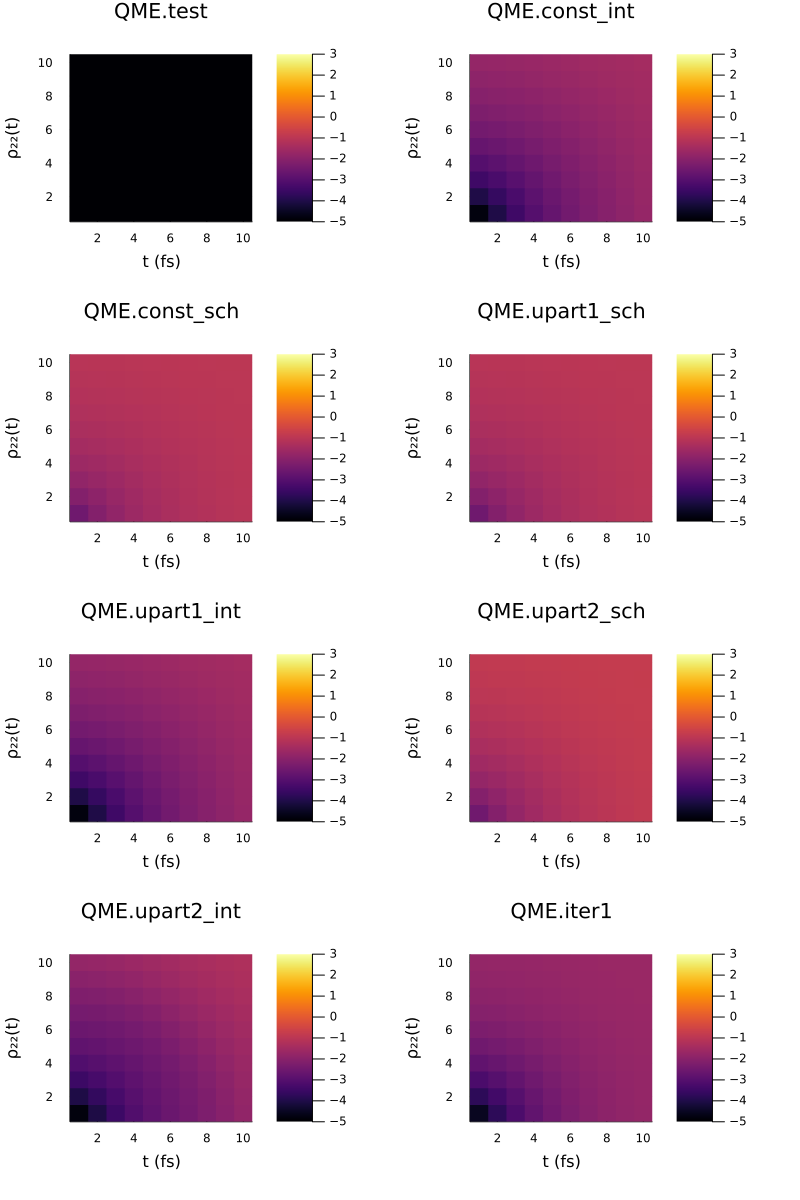

In [9]:
p_l = []
for li=2:9
    heatmap(log10.(score_int[li, 2, 2, :, :]), clim=(-5, 3))
    p = plot!(
        ylabel="ρ₂₂(t)", xlabel="t (fs)",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], p_l[3], p_l[4], 
    p_l[5], p_l[6], p_l[7], p_l[8], 
    layout = (4, 2), margin = 5mm, size=(4*200,2*600)
)

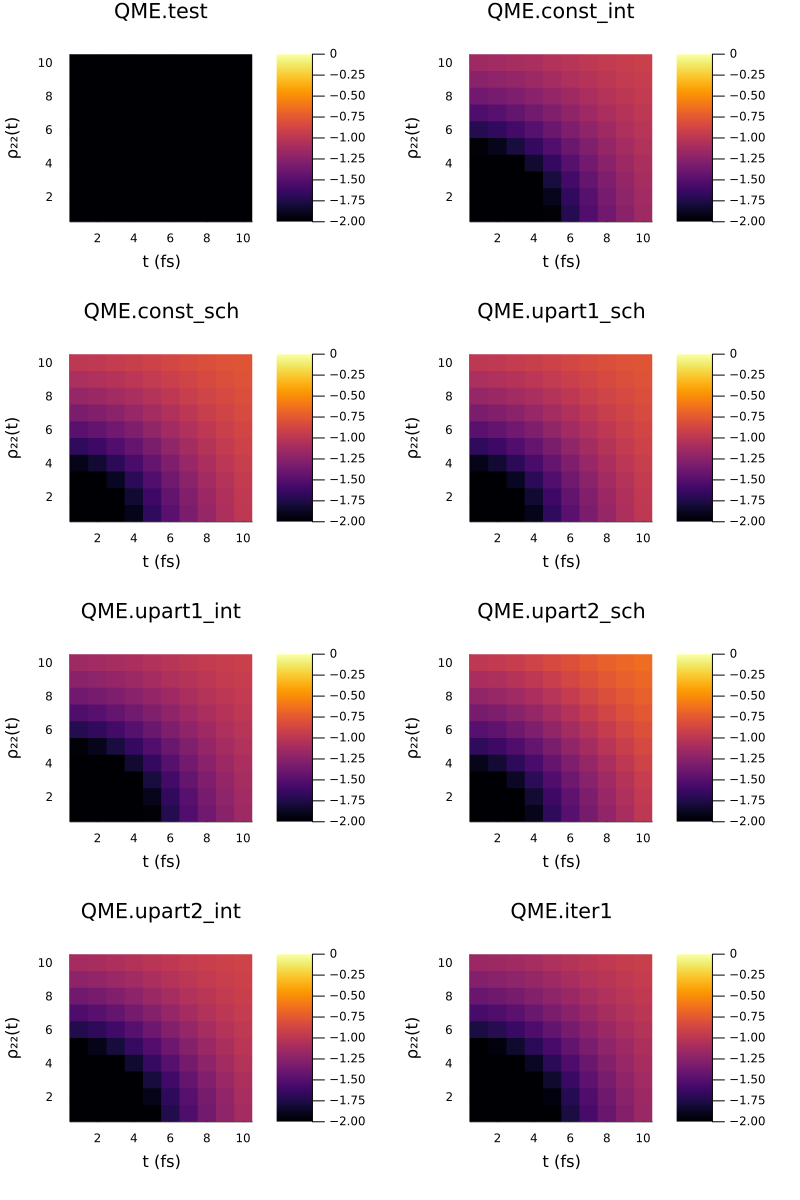

In [10]:
p_l = []
for li=2:9
    heatmap(log10.(score_int[li, 2, 3, :, :]), clim=(-2, 0))
    p = plot!(
        ylabel="ρ₂₂(t)", xlabel="t (fs)",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], p_l[3], p_l[4], 
    p_l[5], p_l[6], p_l[7], p_l[8], 
    layout = (4, 2), margin = 5mm, size=(4*200,2*600)
)

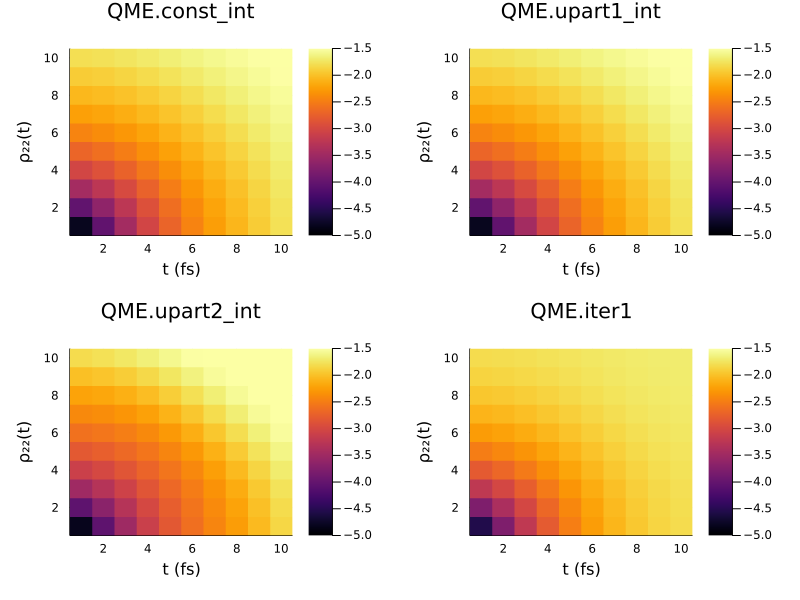

In [29]:
p_l = []
for li in [3, 6, 8, 9]
    heatmap(log10.(score_int[li, 2, 2, :, :]), clim=(-5, -1.5))
    p = plot!(
        ylabel="ρ₂₂(t)", xlabel="t (fs)",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], p_l[3], p_l[4],
    layout = (2, 2), margin = 5mm, size=(800,600)
)

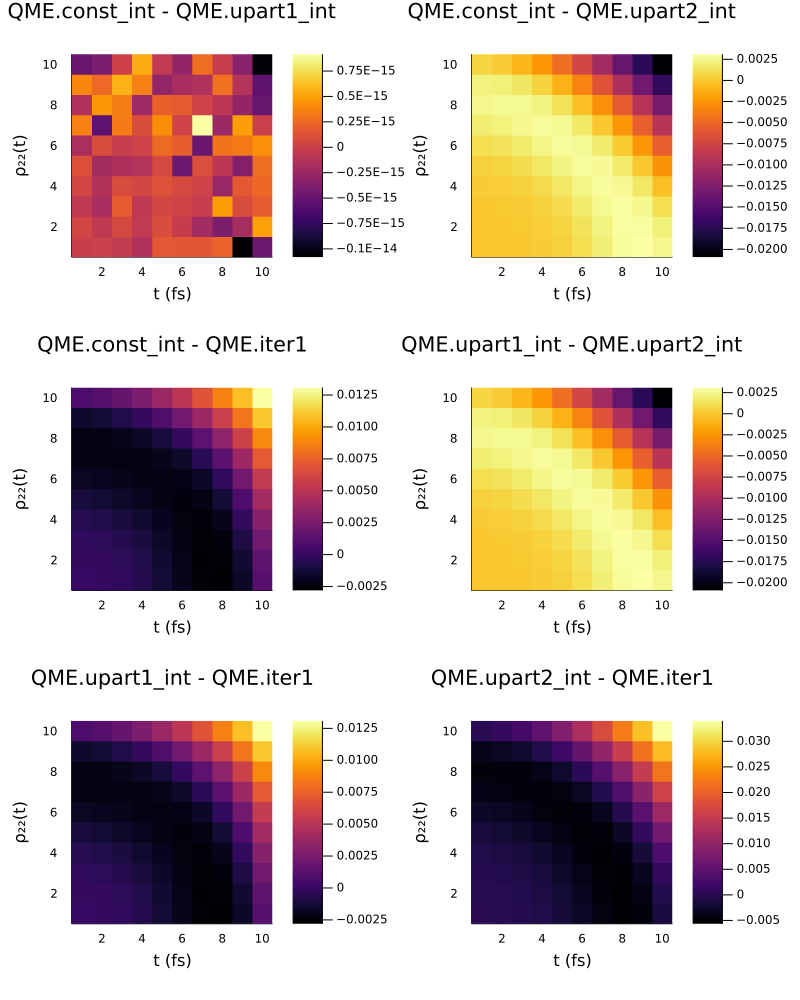

In [12]:
p_l = []
li_subset = [3, 6, 8, 9]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(score_int[li, 2, 2, :, :] - score_int[lj, 2, 2, :, :])
        p = plot!(
            ylabel="ρ₂₂(t)", xlabel="t (fs)",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(800,1000)
)

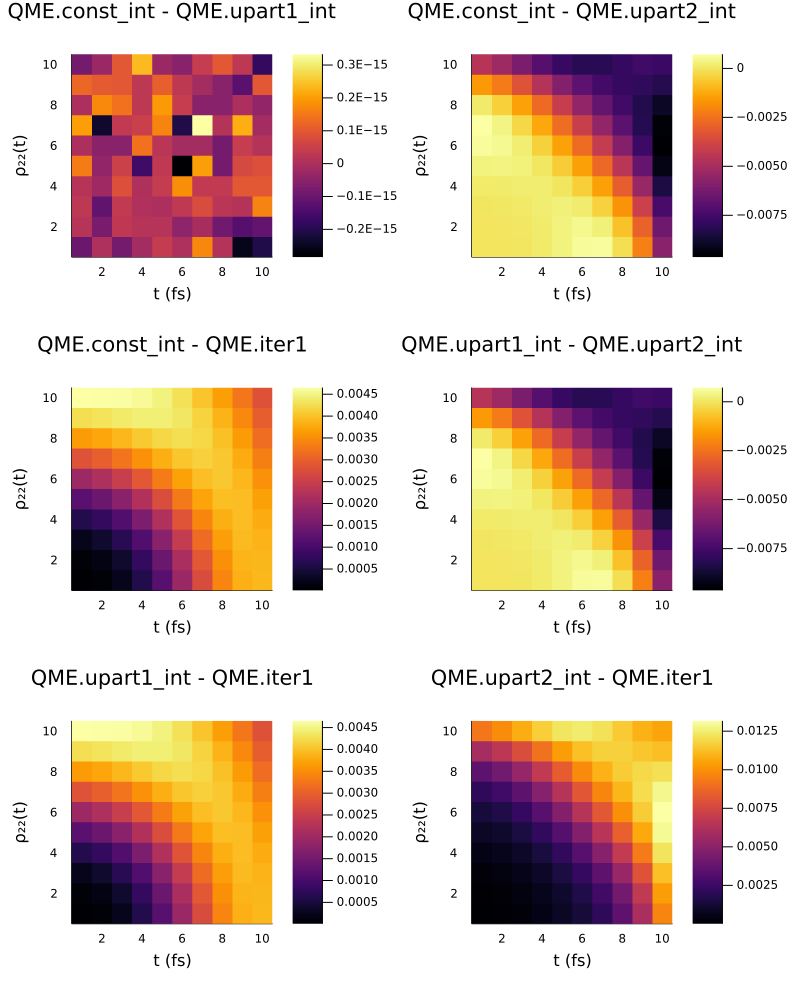

In [13]:
p_l = []
li_subset = [3, 6, 8, 9]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(score_int[li, 2, 3, :, :] - score_int[lj, 2, 3, :, :])
        p = plot!(
            ylabel="ρ₂₂(t)", xlabel="t (fs)",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(800,1000)
)

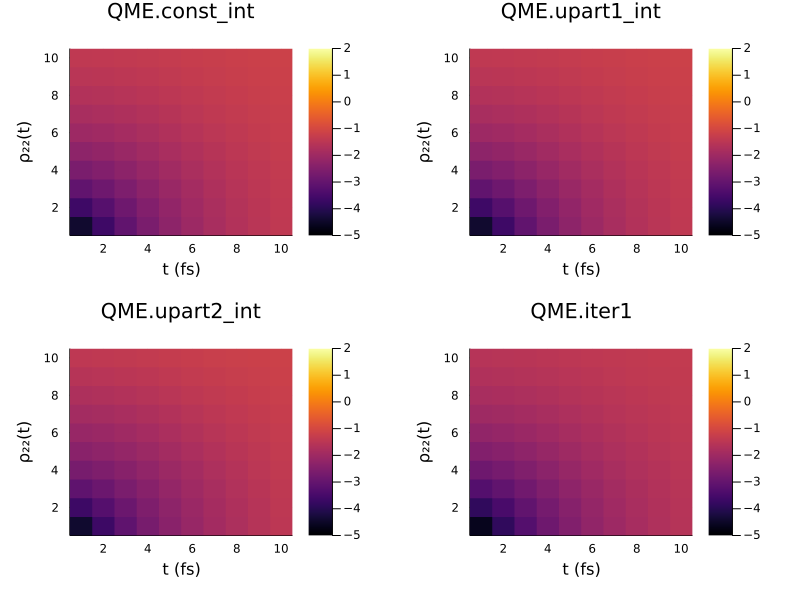

In [14]:
p_l = []
for li in [3, 6, 8, 9]
    heatmap(log10.(score_sch[li, 2, 2, :, :]), clim=(-5, 2))
    p = plot!(
        ylabel="ρ₂₂(t)", xlabel="t (fs)",
        dpi=400, title=labels[li]
    )
    push!(p_l, p)
end

plot(
    p_l[1], p_l[2], p_l[3], p_l[4],
    layout = (2, 2), margin = 5mm, size=(800,600)
)

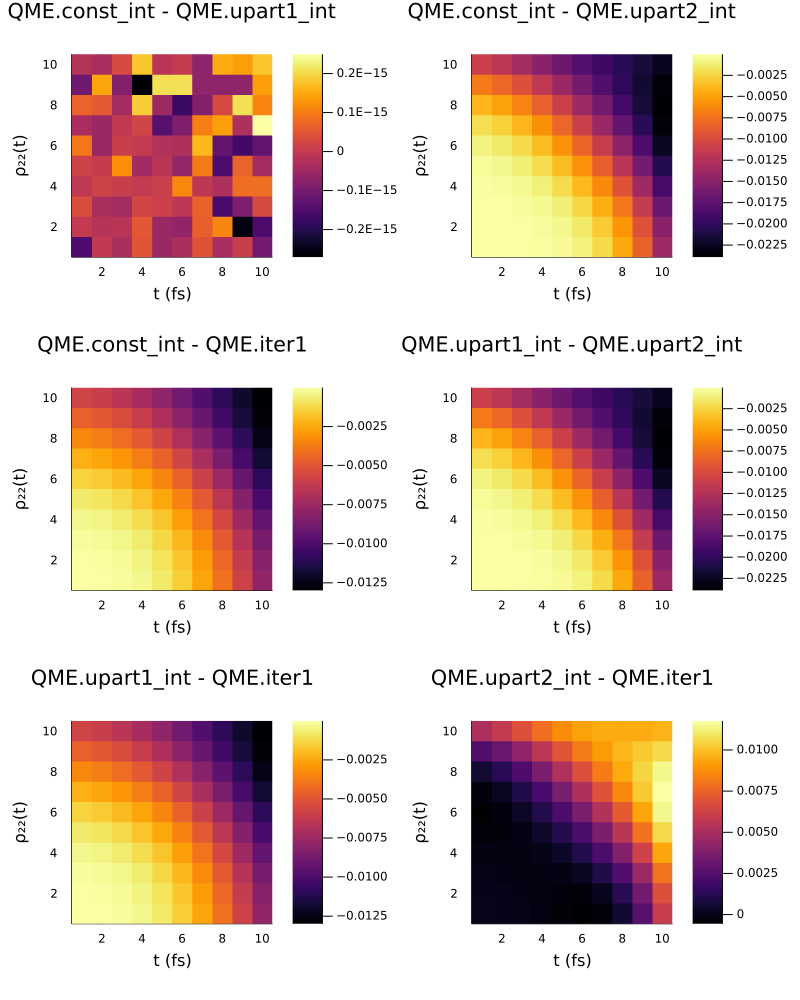

In [15]:
p_l = []
li_subset = [3, 6, 8, 9]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(score_sch[li, 2, 3, :, :] - score_sch[lj, 2, 3, :, :])
        p = plot!(
            ylabel="ρ₂₂(t)", xlabel="t (fs)",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(800,1000)
)

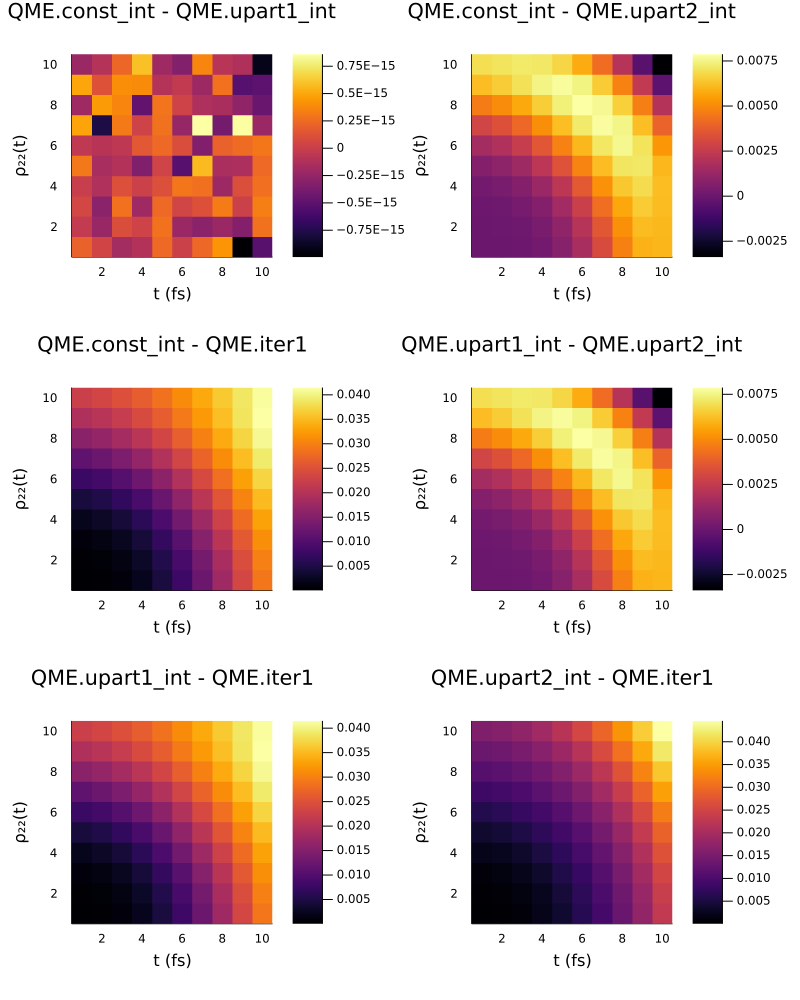

In [38]:
p_l = []
li_subset = [3, 6, 8, 9]
for lii=1:length(li_subset)-1
    li = li_subset[lii]
    label_i = labels[li]
    for ljj=lii+1:length(li_subset)
        lj = li_subset[ljj]
        label_j = labels[lj]
        heatmap(score_exc[li, 2, 2, :, :] - score_exc[lj, 2, 2, :, :])
        p = plot!(
            ylabel="ρ₂₂(t)", xlabel="t (fs)",
            dpi=400, title="$(label_i) - $(label_j)"
        )
        push!(p_l, p)
    end
end

plot(
    p_l[1], p_l[2], p_l[3], 
    p_l[4], p_l[5], p_l[6], 
    layout = (3, 2), margin = 5mm, size=(800,1000)
)

In [30]:
sim_info, rho_int_l = simulation_dic[55]
agg = get_agg(sim_info["hr1"], sim_info["hr2"])
n = sim_info["n"]
hr1_i = n % 10 + 1
hr2_i = n ÷ 10 + 1
println(hr1_i, " ", hr2_i)
for i=1:length(rho_int_l)
    rho_int_l[i] = operator_recast(rho_int_l[i])
end
rho_l = []
for i=1:length(rho_int_l)
    push!(rho_l, interaction_pic_to_schroedinger_pic(rho_int_l[i], tspan, agg))
end

rho_exc_l = []
for i=1:length(rho_int_l)
    push!(rho_exc_l, local_st_to_exciton_st(rho_l[i], agg))
end
println("")

6 6



In [31]:
sim_labels

9-element Vector{String}:
 "Evolution_sI_exact"
 "QME_sI_ansatz_test"
 "QME_sI_ansatz_const_int"
 "QME_sI_ansatz_const_sch"
 "QME_sI_ansatz_upart1_sch"
 "QME_sI_ansatz_upart1_int"
 "QME_sI_ansatz_upart2_sch"
 "QME_sI_ansatz_upart2_int"
 "QME_sI_iterative_1"

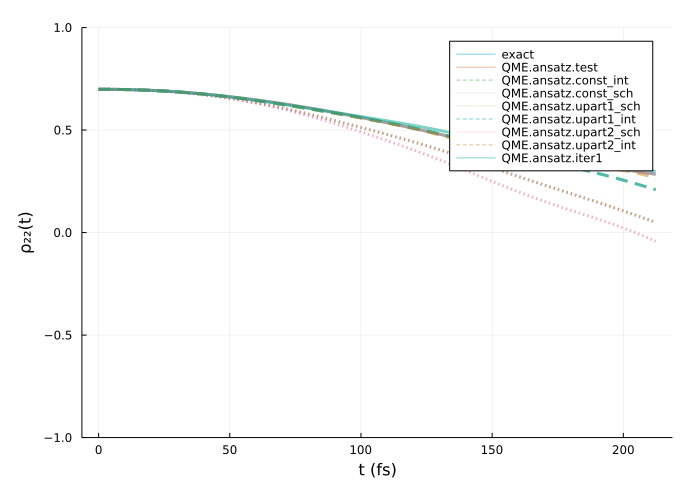

In [32]:
n, m = 2, 2
plot(tspan_fs, real(rho_int_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[3][:, n, m]), label="QME.ansatz.const_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[4][:, n, m]), label="QME.ansatz.const_sch", linealpha = 0.5, linewidth = 3, linestyle = :dot)
plot!(tspan_fs, real(rho_int_l[5][:, n, m]), label="QME.ansatz.upart1_sch", linealpha = 0.5, linewidth = 3, linestyle = :dot)
plot!(tspan_fs, real(rho_int_l[6][:, n, m]), label="QME.ansatz.upart1_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[7][:, n, m]), label="QME.ansatz.upart2_sch", linealpha = 0.5, linewidth = 3, linestyle = :dot)
plot!(tspan_fs, real(rho_int_l[8][:, n, m]), label="QME.ansatz.upart2_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[9][:, n, m]), label="QME.ansatz.iter1", linealpha = 0.5, linewidth = 3, linestyle = :solid)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500), ylim=(-1, 1))

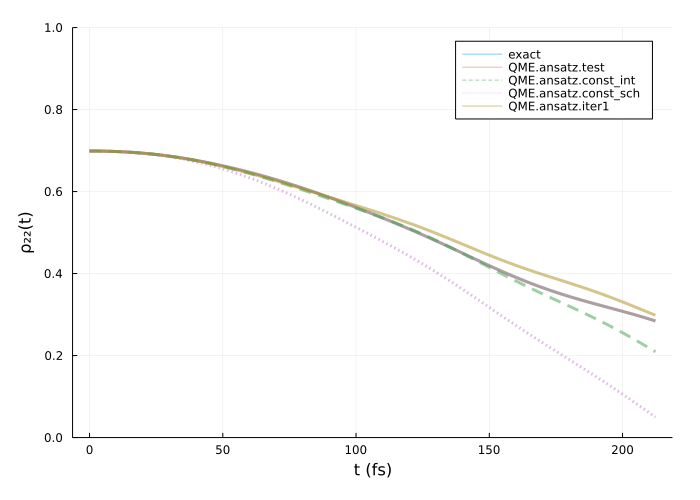

In [34]:
n, m = 2, 2
plot(tspan_fs, real(rho_int_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[3][:, n, m]), label="QME.ansatz.const_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[4][:, n, m]), label="QME.ansatz.const_sch", linealpha = 0.5, linewidth = 3, linestyle = :dot)
plot!(tspan_fs, real(rho_int_l[9][:, n, m]), label="QME.ansatz.iter1", linealpha = 0.5, linewidth = 3, linestyle = :solid)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500), ylim=(0, 1))

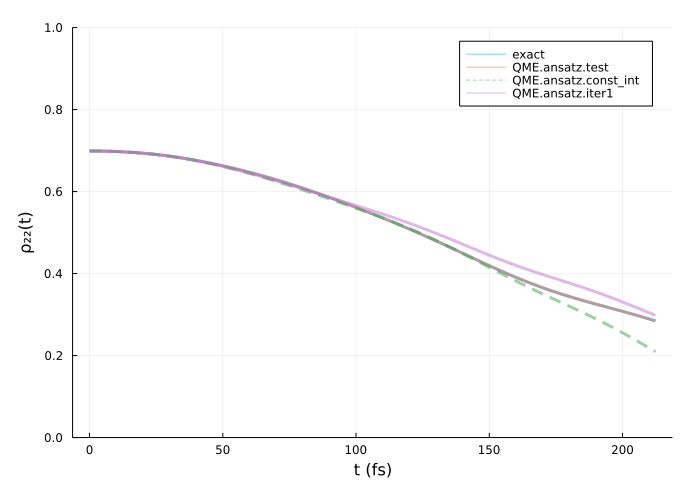

In [36]:
n, m = 2, 2
plot(tspan_fs, real(rho_int_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_int_l[3][:, n, m]), label="QME.ansatz.const_int", linealpha = 0.5, linewidth = 3, linestyle = :dash)
plot!(tspan_fs, real(rho_int_l[9][:, n, m]), label="QME.ansatz.iter1", linealpha = 0.5, linewidth = 3, linestyle = :solid)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500), ylim=(0, 1))

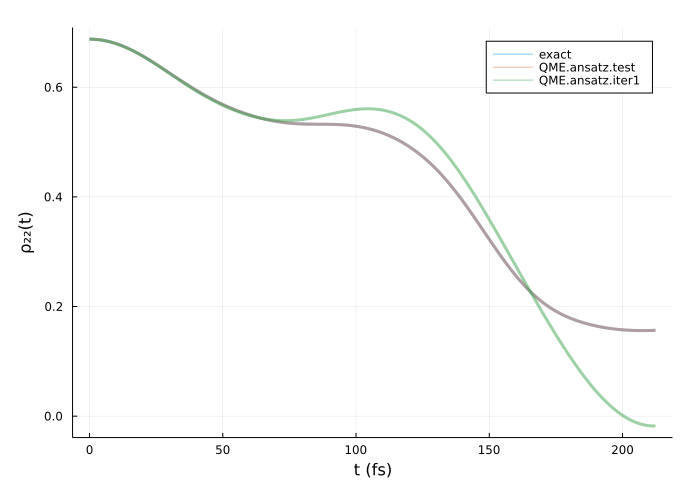

In [26]:
n, m = 2, 2
plot(tspan_fs, real(rho_l[1][:, n, m]), label="exact", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_l[2][:, n, m]), label="QME.ansatz.test", linealpha = 0.5, linewidth = 3, linestyle = :solid)
plot!(tspan_fs, real(rho_l[9][:, n, m]), label="QME.ansatz.iter1", linealpha = 0.5, linewidth = 3, linestyle = :solid)

p = plot!(ylabel="ρ₂₂(t)", xlabel="t (fs)", margin = 5mm, dpi=400, size=(700,500))